In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input

warnings.filterwarnings('ignore')

In [2]:
def data_prep(MildDementia, ModerateDementia, VerymildDementia, NonDemented):

    MildDementia= ["../input/imagesoasis/Data/Mild Dementia" + '/' +  MildDementia for MildDementia in MildDementia]
    ModerateDementia= ["../input/imagesoasis/Data/Moderate Dementia"  + '/' +  ModerateDementia for ModerateDementia in ModerateDementia]
    VerymildDementia= ["../input/imagesoasis/Data/Very mild Dementia"  + '/' +  VerymildDementia for VerymildDementia in VerymildDementia]
    NonDemented= ["../input/imagesoasis/Data/Non Demented"  + '/' +  NonDemented for NonDemented in NonDemented]

    labels = len(MildDementia)*['MildDementia'] + len(ModerateDementia)*['ModerateDementia'] + len(VerymildDementia)*['VerymildDementia'] + len(NonDemented)*['NonDemented']
    data = MildDementia + ModerateDementia + VerymildDementia + NonDemented

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [3]:
df = data_prep(os.listdir('../input/imagesoasis/Data/Mild Dementia'), os.listdir('../input/imagesoasis/Data/Moderate Dementia'),
               os.listdir('../input/imagesoasis/Data/Very mild Dementia'), os.listdir('../input/imagesoasis/Data/Non Demented'))

In [4]:
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.sample(10)

,Image_Path,Labels
82546,../input/imagesoasis/Data/Non Demented/OAS1_02...,NonDemented
36407,../input/imagesoasis/Data/Non Demented/OAS1_03...,NonDemented
73563,../input/imagesoasis/Data/Non Demented/OAS1_03...,NonDemented
85515,../input/imagesoasis/Data/Non Demented/OAS1_03...,NonDemented
72311,../input/imagesoasis/Data/Non Demented/OAS1_02...,NonDemented
5250,../input/imagesoasis/Data/Mild Dementia/OAS1_0...,MildDementia
4595,../input/imagesoasis/Data/Very mild Dementia/O...,VerymildDementia
28389,../input/imagesoasis/Data/Very mild Dementia/O...,VerymildDementia
4401,../input/imagesoasis/Data/Non Demented/OAS1_03...,NonDemented
50071,../input/imagesoasis/Data/Non Demented/OAS1_01...,NonDemented


In [6]:
def plot_images(class_label, df, num_images=5):

    class_df = df[df['Labels'] == class_label].head(num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()

    for i, (img_path) in enumerate(class_df['Image_Path']):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'{class_label} - Image {i+1}')

    plt.tight_layout()
    plt.show()

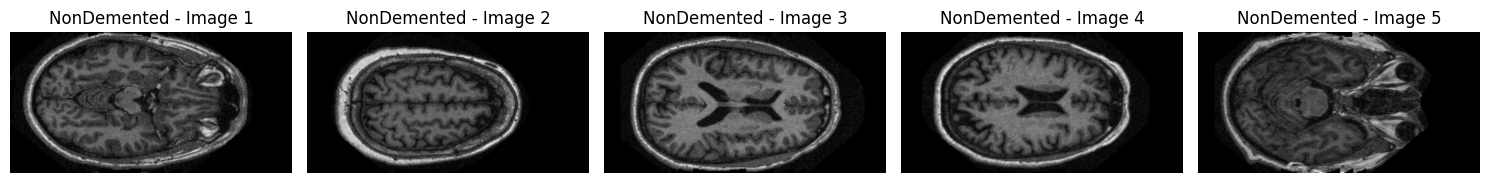

In [7]:
plot_images('NonDemented', df)

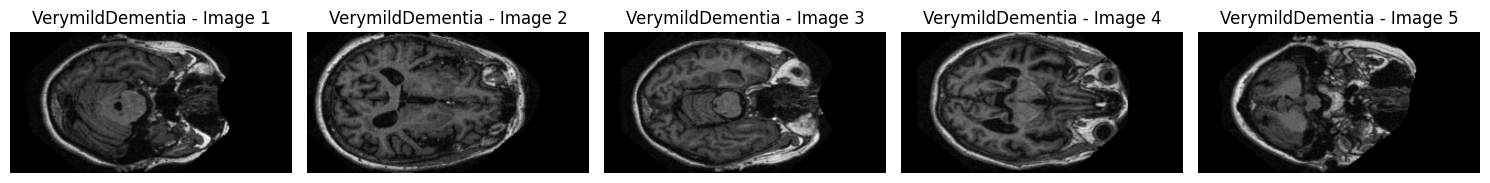

In [8]:
plot_images('VerymildDementia', df)

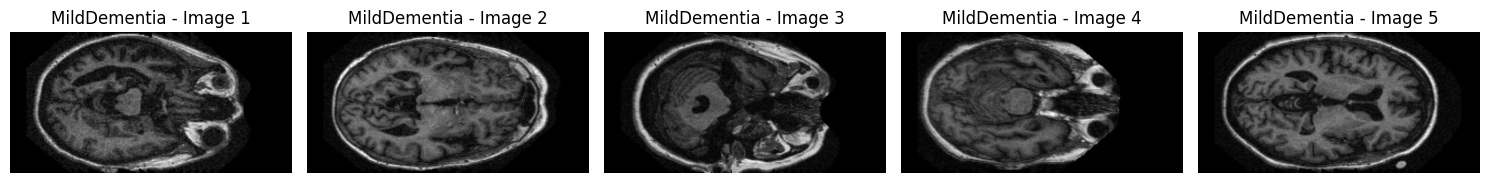

In [9]:
plot_images('MildDementia', df)

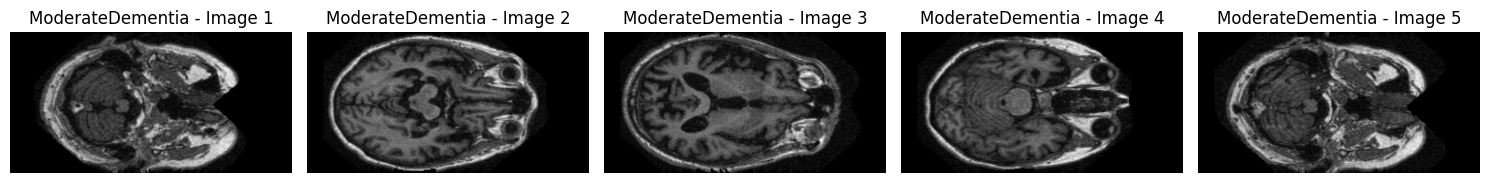

In [10]:
plot_images('ModerateDementia', df)

In [11]:
df.Labels.value_counts()

Labels
NonDemented         67222
VerymildDementia    13725
MildDementia         5002
ModerateDementia      488
Name: count, dtype: int64

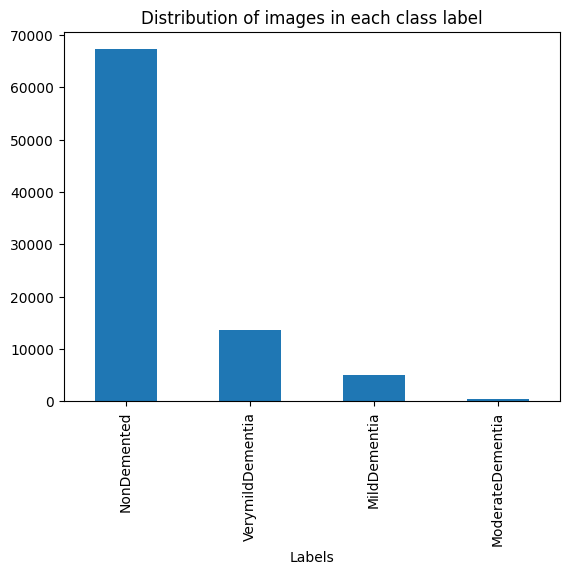

In [12]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label')
plt.show()

### Data is imbalanced hence reducing the data size by using the sample images from majority classes

In [13]:
df = df.groupby('Labels').apply(lambda x: x.sample(n=2000, random_state=42) if x['Labels'].iloc[0] in ['NonDemented', 'VerymildDementia', 'MildDementia'] else x)
df = df.reset_index(drop=True)

In [14]:
df.Labels.value_counts()

Labels
MildDementia        2000
NonDemented         2000
VerymildDementia    2000
ModerateDementia     488
Name: count, dtype: int64

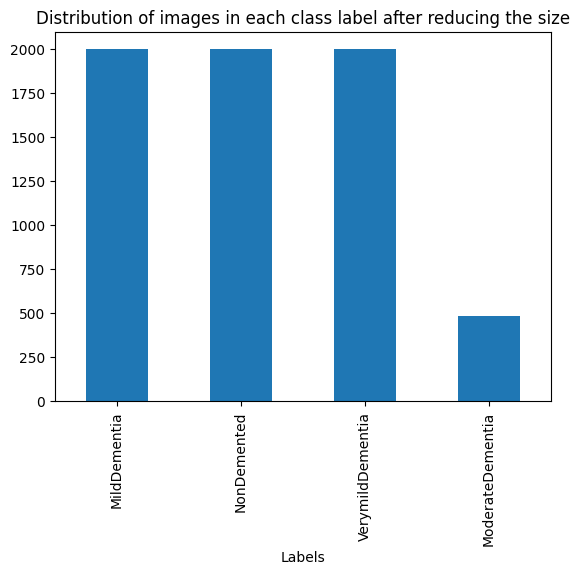

In [15]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label after reducing the size')
plt.show()

### Adding the Higher weight to the ModerateDementia class such that the CNN models will treat all classes more equally

In [16]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = df.Labels.value_counts().to_dict()
classes = list(class_counts.keys())
total_samples = sum(class_counts.values())
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=df.Labels)
class_weights_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

print("Class Weights:", class_weights_dict)

Class Weights: {'MildDementia': 0.811, 'NonDemented': 0.811, 'VerymildDementia': 0.811, 'ModerateDementia': 3.3237704918032787}


NOTE: SMOTE (Synthetic Minority Over-sampling Technique) cannot be directly applied to an image dataset. SMOTE generates synthetic samples by interpolating between existing data points in a numerical feature space. Images are high-dimensional and contain pixel-based spatial structures, which SMOTE does not preserve. Also, SMOTE assumes that linear interpolation between feature vectors creates meaningful new samples. For images, simply blending two MRI scans would create unrealistic or distorted data. MRI scans follow a specific anatomical structure. Generating synthetic images through numerical interpolation can create unrealistic and biologically meaningless samples. Hence, I have applied undersampling and then added class weights to treat all classes more equally - This prevents the model from favoring the dominant class and Higher class weight helps the model pay more attention to this underrepresented class during training.

## Data Augmentation

In [17]:
train, test = train_test_split(df, test_size = .30)

In [18]:
datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,                     # File paths are in the dataframe
    x_col='Image_Path',                 # Column with image file paths
    y_col='Labels',                     # Column with labels
    target_size=(224, 224),             # Resize images to 224x224
    batch_size=32,                      # Number of images to process in each batch
    class_mode='categorical',           # Classification task
    shuffle=True                        # Shuffle the data
)

Found 4541 validated image filenames belonging to 4 classes.


In [20]:
def augmented_images(generator, num_images=5):

    for i in range(num_images):
        img, label = next(generator)
        plt.figure(figsize=(5, 5))
        plt.imshow(img[0])
        plt.axis('off')
        plt.show()

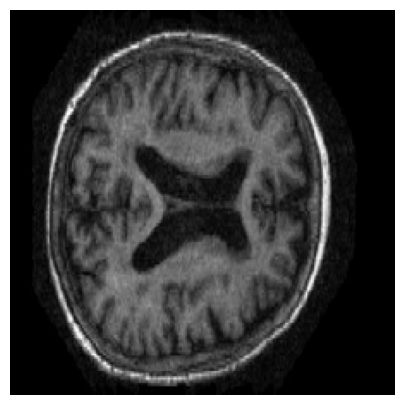

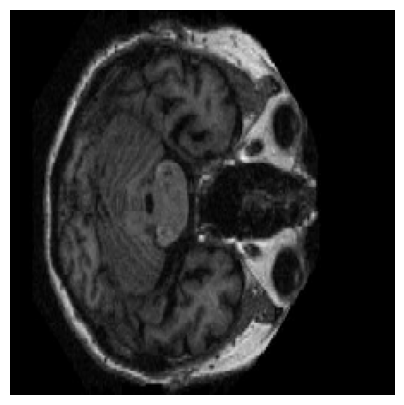

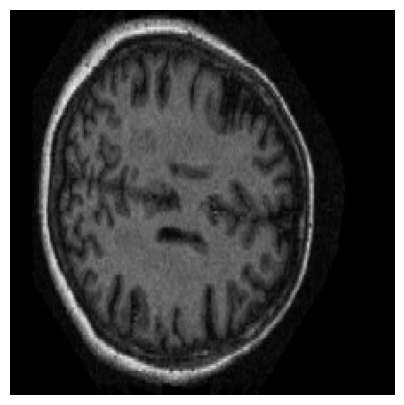

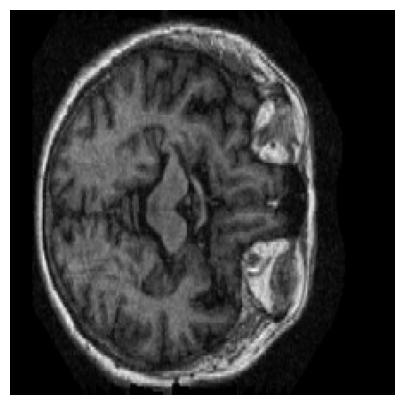

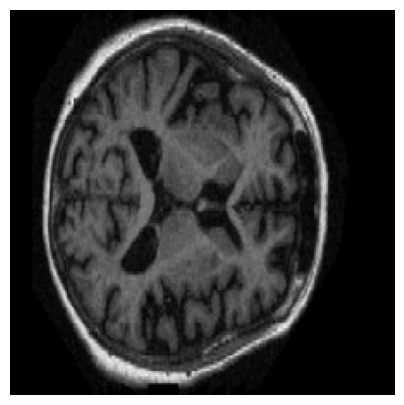

In [21]:
augmented_images(train_generator, num_images=5)

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,                      # File paths are in the dataframe
    x_col='Image_Path',                   # Column with image file paths
    y_col='Labels',                       # Column with labels
    target_size=(224, 224),               # Resize images to 224x224
    batch_size=32,                        # Number of images to process in each batch
    class_mode='categorical',             # Classification task
    shuffle=False                         # Do not shuffle test data
)

Found 1947 validated image filenames belonging to 4 classes.


In [26]:
from tensorflow.keras.metrics import Precision, Recall

In [27]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 
                                                                          Precision(name='precision'), 
                                                                          Recall(name='recall')])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
hist = model.fit(train_generator, epochs=20, validation_data=test_generator, 
                 class_weight=class_weights_dict)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.3678 - loss: 1.3791 - precision: 0.4784 - recall: 0.0804 - val_accuracy: 0.6836 - val_loss: 0.7984 - val_precision: 0.8175 - val_recall: 0.4694
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.6837 - loss: 0.7686 - precision: 0.7644 - recall: 0.5666 - val_accuracy: 0.8408 - val_loss: 0.4605 - val_precision: 0.8735 - val_recall: 0.8053
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.8020 - loss: 0.4975 - precision: 0.8372 - recall: 0.7598 - val_accuracy: 0.8752 - val_loss: 0.3514 - val_precision: 0.9007 - val_recall: 0.8526
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.8615 - loss: 0.3461 - precision: 0.8809 - recall: 0.8425 - val_accuracy: 0.8891 - val_loss: 0.3159 - val_precision: 0.8991 - val_recall: 0.8783
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.8855 - loss: 0.2759 - precision: 0.9017 - recall: 0.8676 - val_accuracy: 0.9050

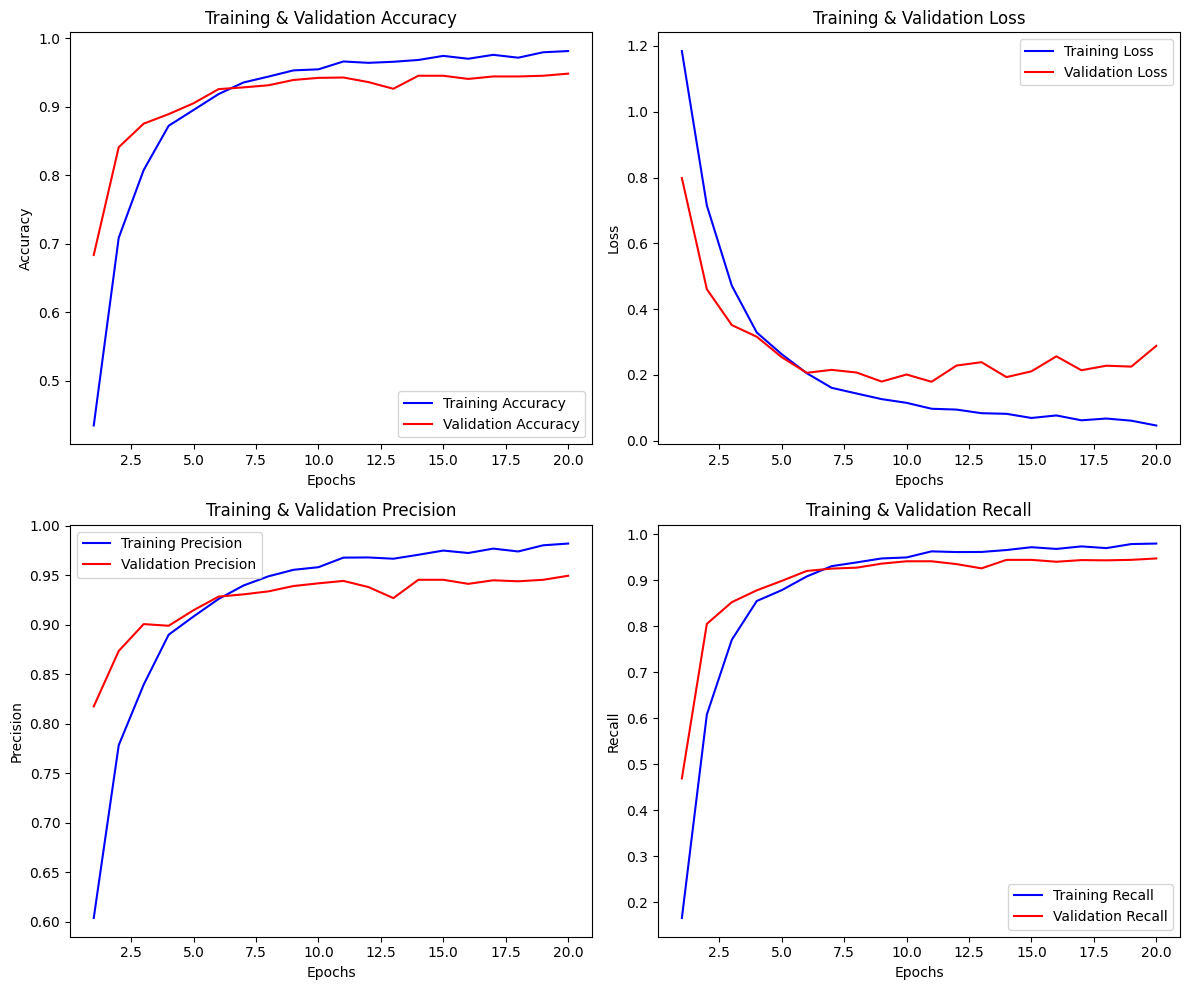

In [29]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
axs[0, 0].plot(epochs, acc, 'b', label='Training Accuracy')
axs[0, 0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0, 0].set_title('Training & Validation Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot Loss
axs[0, 1].plot(epochs, loss, 'b', label='Training Loss')
axs[0, 1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[0, 1].set_title('Training & Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot Precision
axs[1, 0].plot(epochs, precision, 'b', label='Training Precision')
axs[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
axs[1, 0].set_title('Training & Validation Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot Recall
axs[1, 1].plot(epochs, recall, 'b', label='Training Recall')
axs[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
axs[1, 1].set_title('Training & Validation Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [30]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fifth convolutional layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 
                                                                          Precision(name='precision'), 
                                                                          Recall(name='recall')])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,207,620 (12.24 MB)

 Trainable params: 3,207,620 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
hist = model.fit(train_generator, epochs=20, validation_data=test_generator, 
                 class_weight=class_weights_dict)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.2895 - loss: 1.3093 - precision: 0.3808 - recall: 0.0161 - val_accuracy: 0.4576 - val_loss: 1.1394 - val_precision: 0.6046 - val_recall: 0.0817
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.5013 - loss: 1.0880 - precision: 0.6453 - recall: 0.2510 - val_accuracy: 0.6292 - val_loss: 0.8149 - val_precision: 0.7118 - val_recall: 0.4669
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.6730 - loss: 0.7915 - precision: 0.7539 - recall: 0.5244 - val_accuracy: 0.7324 - val_loss: 0.6119 - val_precision: 0.7795 - val_recall: 0.6538
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.7818 - loss: 0.5531 - precision: 0.8215 - recall: 0.7160 - val_accuracy: 0.8100 - val_loss: 0.4707 - val_precision: 0.8388 - val_recall: 0.7725
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.8284 - loss: 0.4308 - precision: 0.8556 - recall: 0.7977 - val_accuracy: 0.8505

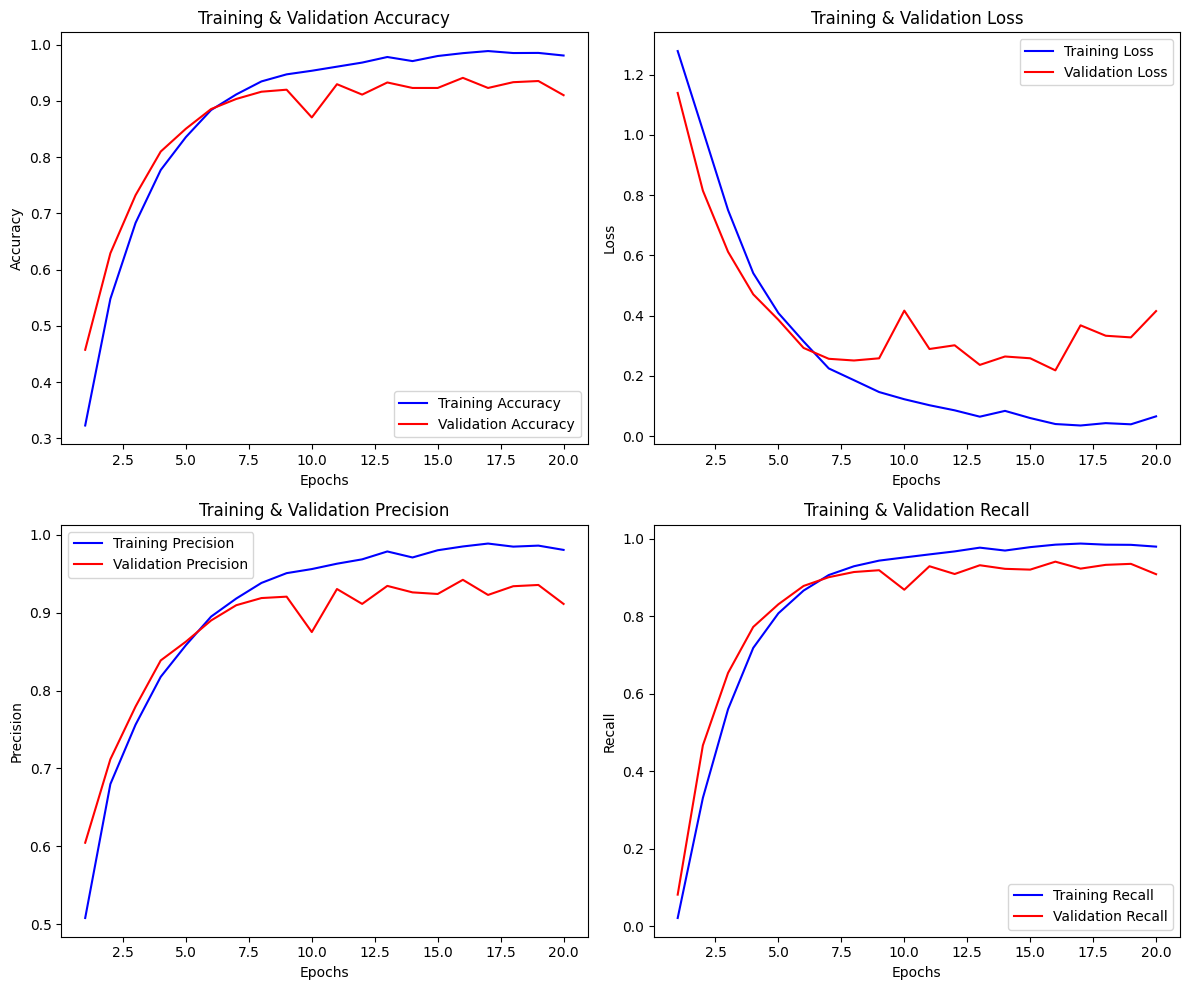

In [32]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
axs[0, 0].plot(epochs, acc, 'b', label='Training Accuracy')
axs[0, 0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0, 0].set_title('Training & Validation Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot Loss
axs[0, 1].plot(epochs, loss, 'b', label='Training Loss')
axs[0, 1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[0, 1].set_title('Training & Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot Precision
axs[1, 0].plot(epochs, precision, 'b', label='Training Precision')
axs[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
axs[1, 0].set_title('Training & Validation Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot Recall
axs[1, 1].plot(epochs, recall, 'b', label='Training Recall')
axs[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
axs[1, 1].set_title('Training & Validation Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [33]:
input_shape = (224, 224, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 
                                                                          Precision(name='precision'), 
                                                                          Recall(name='recall')])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
hist = model.fit(train_generator, epochs=20, validation_data=test_generator, 
                 class_weight=class_weights_dict)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 433ms/step - accuracy: 0.3511 - loss: 1.8184 - precision: 0.4254 - recall: 0.1618 - val_accuracy: 0.5901 - val_loss: 1.1297 - val_precision: 1.0000 - val_recall: 0.0144
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.4528 - loss: 1.1363 - precision: 0.7106 - recall: 0.1561 - val_accuracy: 0.6656 - val_loss: 0.9274 - val_precision: 0.8945 - val_recall: 0.2090
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 31s 212ms/step - accuracy: 0.4973 - loss: 1.0306 - precision: 0.7126 - recall: 0.2857 - val_accuracy: 0.7360 - val_loss: 0.8260 - val_precision: 0.9063 - val_recall: 0.3775
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.5154 - loss: 0.9918 - precision: 0.6916 - recall: 0.3353 - val_accuracy: 0.7175 - val_loss: 0.7998 - val_precision: 0.8963 - val_recall: 0.4217
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.5269 - loss: 0.9711 - precision: 0.7053 - recall: 0.3465 - val_accuracy: 0.7355

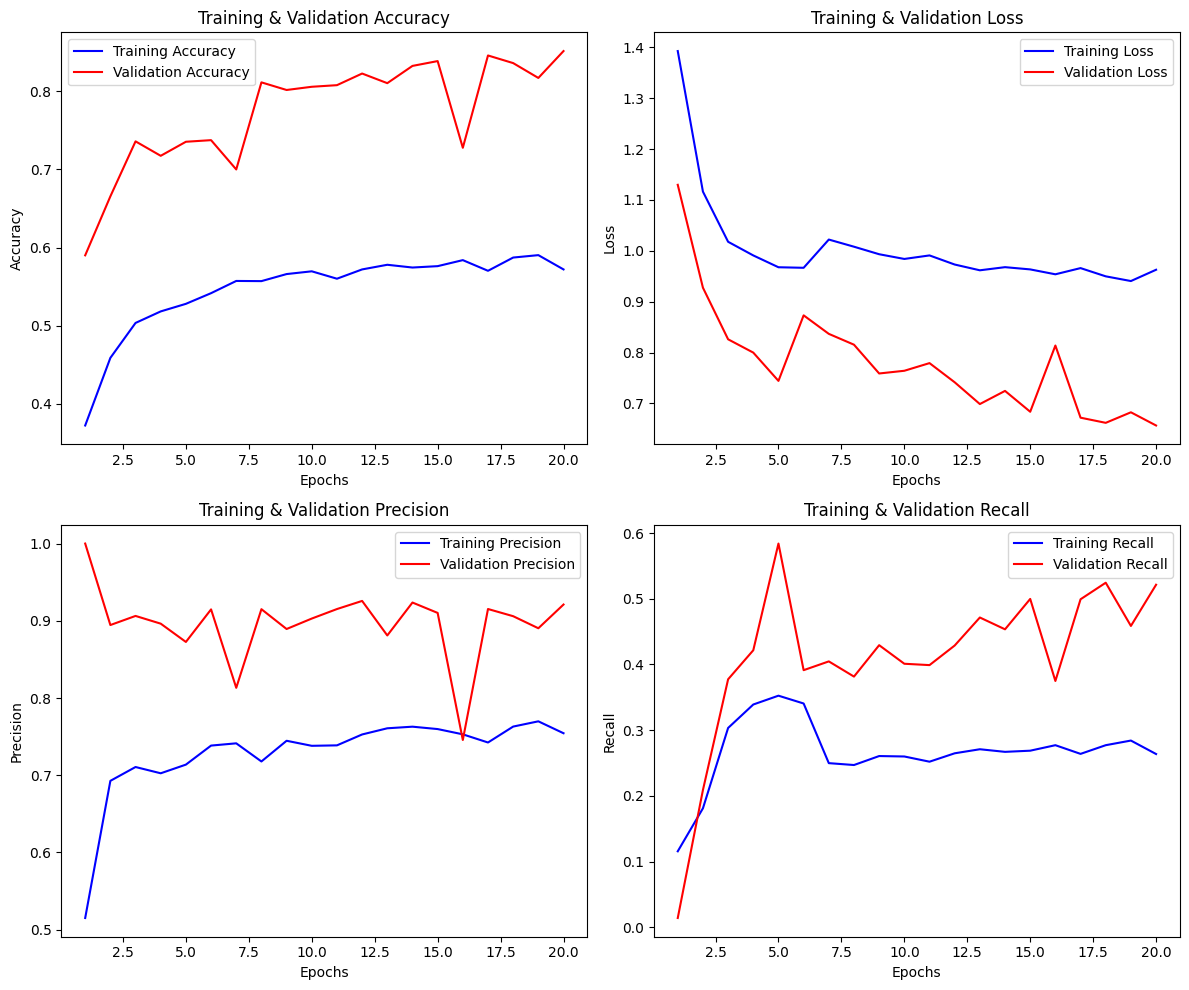

In [35]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
axs[0, 0].plot(epochs, acc, 'b', label='Training Accuracy')
axs[0, 0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0, 0].set_title('Training & Validation Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot Loss
axs[0, 1].plot(epochs, loss, 'b', label='Training Loss')
axs[0, 1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[0, 1].set_title('Training & Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot Precision
axs[1, 0].plot(epochs, precision, 'b', label='Training Precision')
axs[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
axs[1, 0].set_title('Training & Validation Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot Recall
axs[1, 1].plot(epochs, recall, 'b', label='Training Recall')
axs[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
axs[1, 1].set_title('Training & Validation Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [36]:
input_shape = (224, 224, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 
                                                                          Precision(name='precision'), 
                                                                          Recall(name='recall')])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 36,433,412 (138.98 MB)

 Trainable params: 12,845,700 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [37]:
hist = model.fit(train_generator, epochs=20, validation_data=test_generator, 
                 class_weight=class_weights_dict)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - accuracy: 0.2881 - loss: 4.0411 - precision: 0.2412 - recall: 0.0836 - val_accuracy: 0.3118 - val_loss: 1.3610 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.2926 - loss: 1.3557 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3092 - val_loss: 1.3376 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.2916 - loss: 1.3368 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3118 - val_loss: 1.3205 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.3187 - loss: 1.3202 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3092 - val_loss: 1.3082 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.3037 - loss: 1.3137 - p

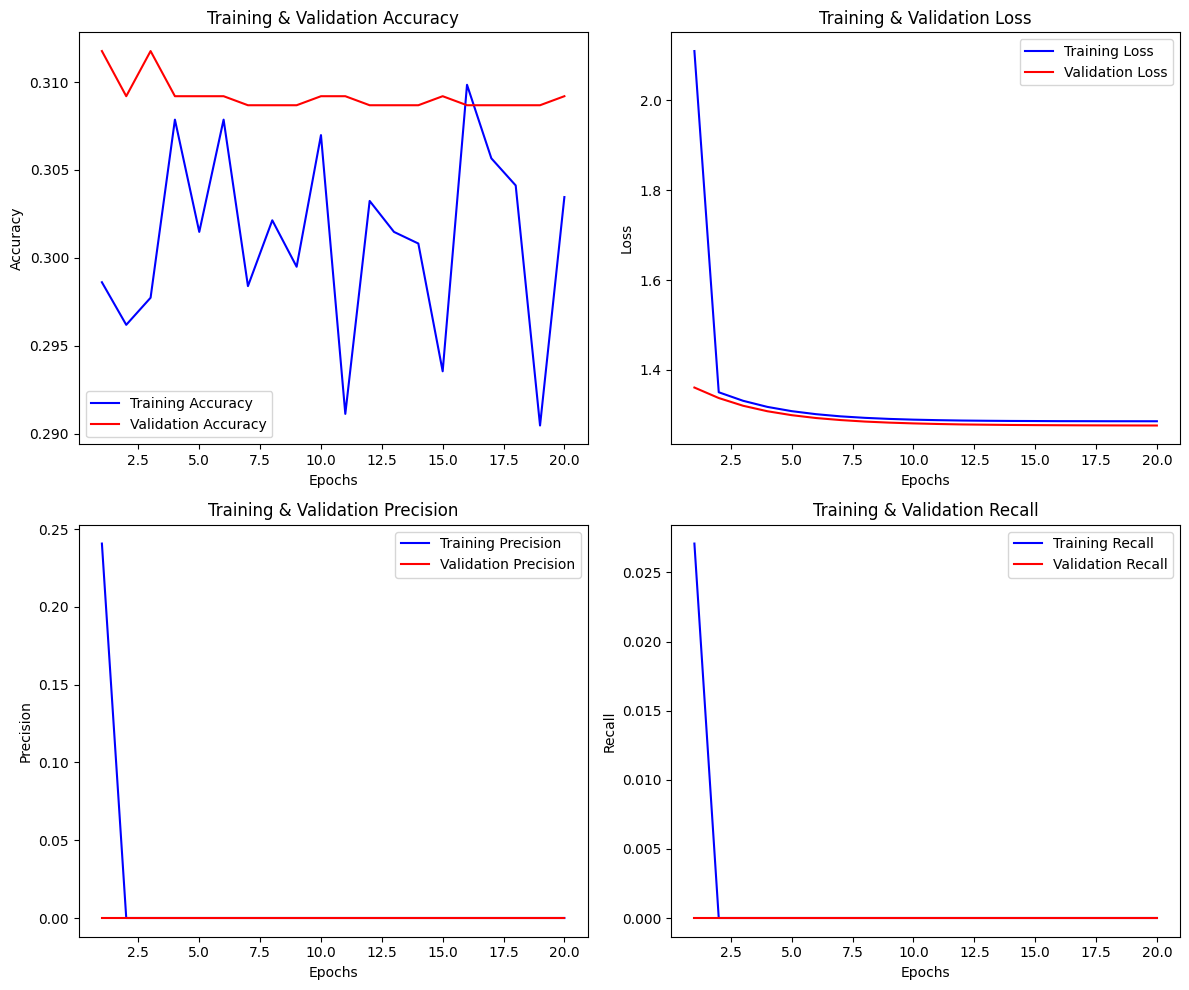

In [38]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
axs[0, 0].plot(epochs, acc, 'b', label='Training Accuracy')
axs[0, 0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0, 0].set_title('Training & Validation Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot Loss
axs[0, 1].plot(epochs, loss, 'b', label='Training Loss')
axs[0, 1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[0, 1].set_title('Training & Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot Precision
axs[1, 0].plot(epochs, precision, 'b', label='Training Precision')
axs[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
axs[1, 0].set_title('Training & Validation Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot Recall
axs[1, 1].plot(epochs, recall, 'b', label='Training Recall')
axs[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
axs[1, 1].set_title('Training & Validation Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [39]:
input_shape = (224, 224, 3)

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 
                                                                          Precision(name='precision'), 
                                                                          Recall(name='recall')])
model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 71,216,644 (271.67 MB)

 Trainable params: 12,845,700 (49.00 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [40]:
hist = model.fit(train_generator, epochs=20, validation_data=test_generator, 
                 class_weight=class_weights_dict)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 94s 492ms/step - accuracy: 0.2994 - loss: 3.6256 - precision: 0.2880 - recall: 0.0858 - val_accuracy: 0.3241 - val_loss: 1.2706 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 354ms/step - accuracy: 0.3029 - loss: 1.2934 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3467 - val_loss: 1.1918 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - accuracy: 0.3149 - loss: 1.2718 - precision: 0.0991 - recall: 1.3875e-04 - val_accuracy: 0.3796 - val_loss: 1.2016 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 349ms/step - accuracy: 0.3170 - loss: 1.2504 - precision: 0.4925 - recall: 0.0035 - val_accuracy: 0.3426 - val_loss: 1.1693 - val_precision: 1.0000 - val_recall: 0.0036
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 347ms/step - accuracy: 0.3156 - loss: 1.2533 - precision: 0.5322 - r

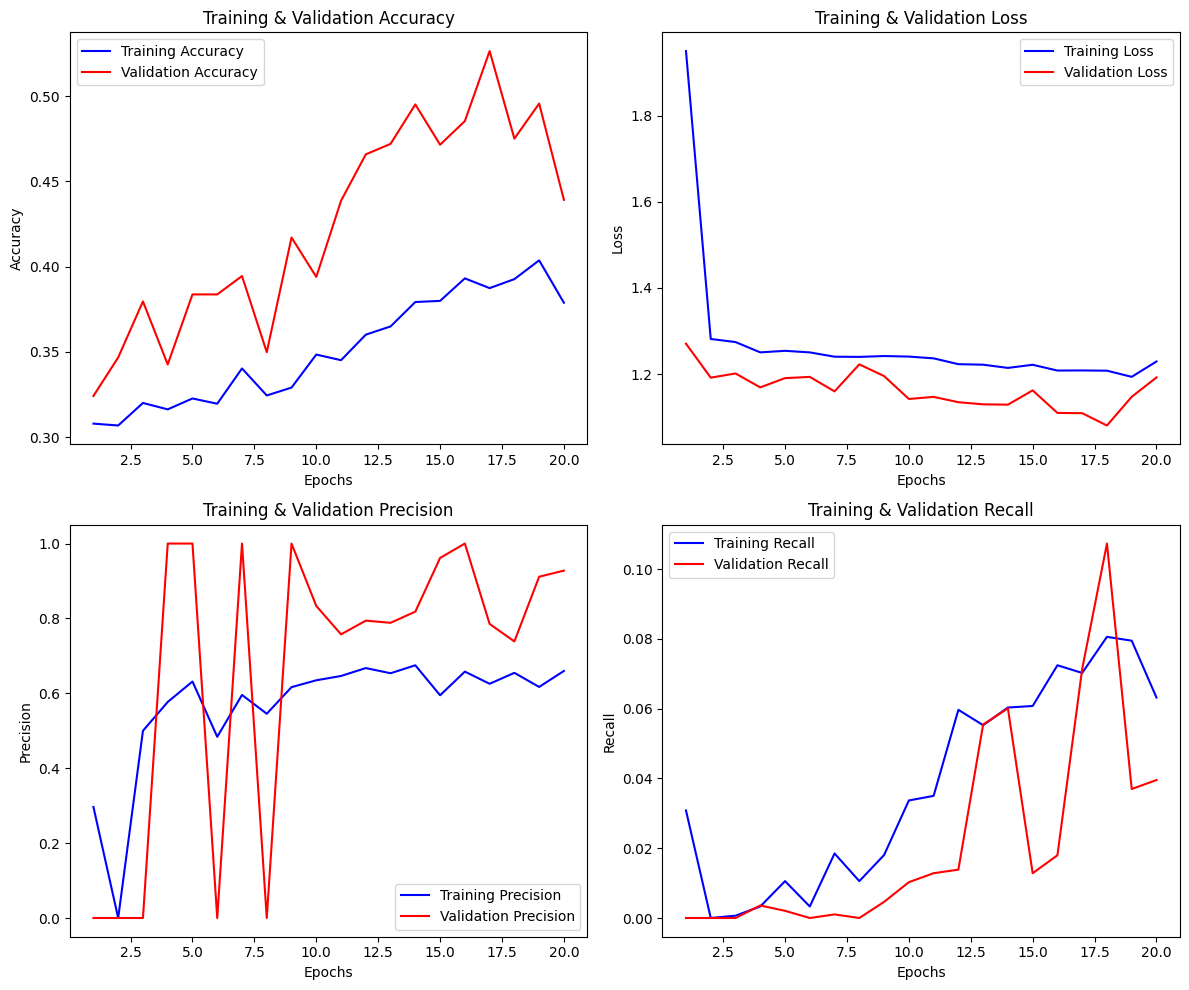

In [41]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
axs[0, 0].plot(epochs, acc, 'b', label='Training Accuracy')
axs[0, 0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0, 0].set_title('Training & Validation Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot Loss
axs[0, 1].plot(epochs, loss, 'b', label='Training Loss')
axs[0, 1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[0, 1].set_title('Training & Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot Precision
axs[1, 0].plot(epochs, precision, 'b', label='Training Precision')
axs[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
axs[1, 0].set_title('Training & Validation Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot Recall
axs[1, 1].plot(epochs, recall, 'b', label='Training Recall')
axs[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
axs[1, 1].set_title('Training & Validation Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()